Plotting intensity for m = 0
Plotting intensity for m = 1
Plotting intensity for m = 5
Plotting intensity for m = -5
Plotting intensity for m = 10


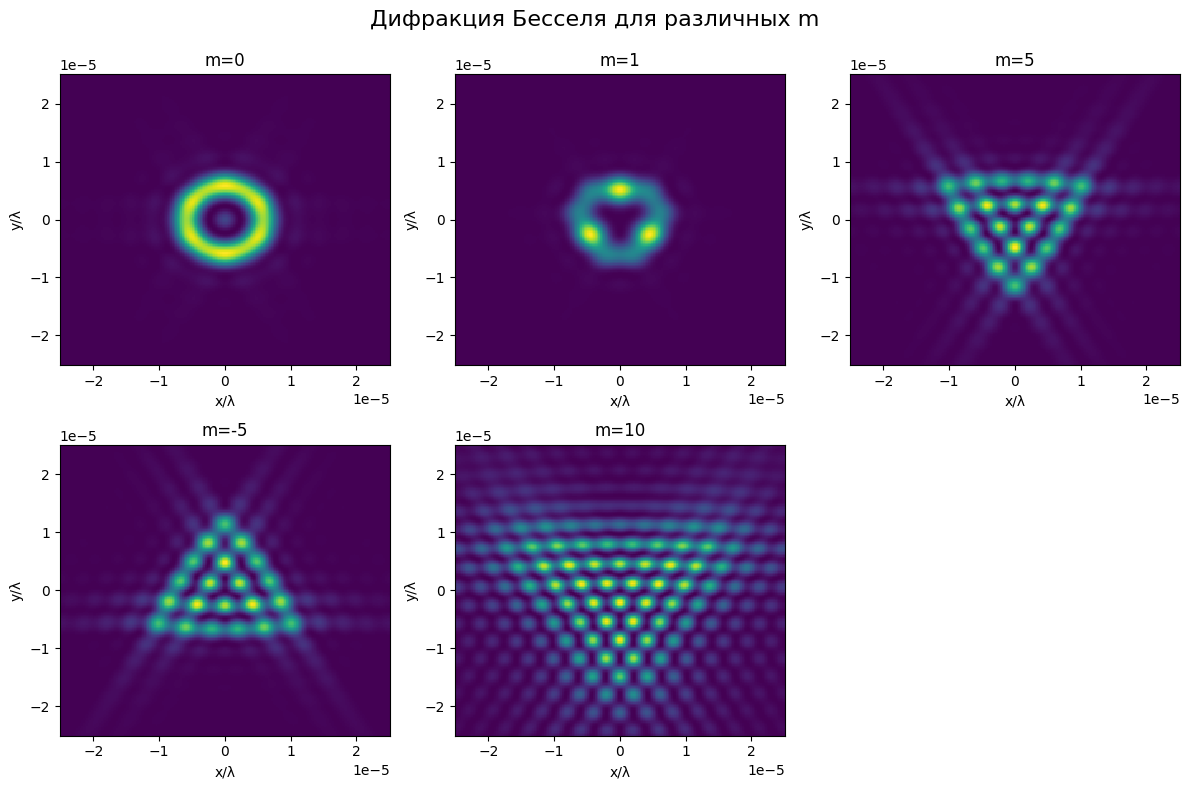

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv

def triangle_vertices(a):
    # Равносторонний треугольник с центром в (0,0)
    h = a * np.sqrt(3) / 2
    vertices = np.array([
        [-a/2, -h/3],
        [a/2, -h/3],
        [0, 2*h/3]
    ])
    return vertices
    
def rotate_points(points, angle_degrees):

    angle_rad = np.radians(angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])
    
    # Применяем матрицу поворота к каждой точке
    rotated_points = np.zeros_like(points)
    for i, point in enumerate(points):
        rotated_points[i] = rotation_matrix @ point
        
    return rotated_points

def is_inside_triangle(xp, yp, vertices, rotation_angle=0):
    # Проверка, лежит ли точка внутри треугольника (барицентрические координаты)

    if rotation_angle != 0:
        vertices = rotate_points(vertices, rotation_angle)
    
    V0, V1, V2 = vertices

    v0, v1, v2 = vertices
    d = (v1[1] - v2[1])*(v0[0] - v2[0]) + (v2[0] - v1[0])*(v0[1] - v2[1])
    a = ((v1[1] - v2[1])*(xp - v2[0]) + (v2[0] - v1[0])*(yp - v2[1])) / d
    b = ((v2[1] - v0[1])*(xp - v2[0]) + (v0[0] - v2[0])*(yp - v2[1])) / d
    c = 1 - a - b
    return (a >= 0) & (b >= 0) & (c >= 0)


def far_field_bessel_triangle(x, y, z, k, kappa, m, a, rotation_angle=0, N=100):
    # x, y — координаты на экране (можно массивы)
    # a — сторона треугольника
    # N — число точек по каждой оси для интегрирования по апертуре
    vertices = triangle_vertices(a)

    # Сетка по апертуре
    xpr = np.linspace(-a/2, a/2, N)
    ypr = np.linspace(-a/2, a/2, N)
    Xp, Yp = np.meshgrid(xpr, ypr)
    mask = is_inside_triangle(Xp, Yp, vertices, rotation_angle)
    Xp = Xp[mask]
    Yp = Yp[mask]

    # Полярные координаты
    Rp = np.sqrt(Xp**2 + Yp**2)
    Phip = np.arctan2(Yp, Xp)

    # Бесселев пучок в апертуре
    A = jv(m, kappa * Rp) * np.exp(1j * m * Phip)

    # Фазовый множитель
    phase = np.exp(-1j * k * (x * Xp + y * Yp) / z)

    # Интеграл по апертуре (суммируем по всем точкам внутри треугольника)
    dS = (a / N)**2  # площадь одного пикселя
    integral = np.sum(A * phase) * dS

    # Общий множитель
    U = (np.exp(1j * k * z) / (1j * z)) * integral
    return U


def plot_combined_intensity(x_range, y_range, intensity_list, m_values):
    """
    Отображение всех интенсивностей на одном графике
    """
    n_plots = len(m_values)

    if n_plots <= 3:
        fig, axes = plt.subplots(1, n_plots, figsize=(n_plots*5, 5))
    else:
        n_cols = int(np.ceil(np.sqrt(n_plots)))
        n_rows = int(np.ceil(n_plots / n_cols))
        
        # Создаем сетку графиков с одинаковым размером
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))

    if n_plots == 1:
        axes = [axes]
    else:
        axes = np.array([axes])

    axes = axes.flatten()

    X, Y = np.meshgrid(x_range, y_range)

    for i, (intensity, m) in enumerate(zip(intensity_list, m_values)):
        if i < len(axes):
            ax = axes[i]
            im = ax.pcolormesh(X, Y, intensity.T, shading='auto', cmap='viridis')
            ax.set_title(f'm={m}')
            ax.set_xlabel('x/λ')
            ax.set_ylabel('y/λ')

    for i in range(len(intensity_list), len(axes)):
        axes[i].axis('off')

    plt.suptitle('Дифракция Бесселя для различных m', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

lambda_val = 0.5e-6  # длина волны, м
k_wave = 2 * np.pi / lambda_val

triangle_a_norm = 7  # сторона треугольника в длинах волн
triangle_a = triangle_a_norm * lambda_val  # в метрах

z_norm = 40.0  # расстояние до экрана в длинах волн
z = z_norm * lambda_val  # в метрах

rotation_angle = 0  # угол поворота треугольника (градусы)

kappa_bessel_factor = 0.3
kappa_bessel = kappa_bessel_factor * k_wave

screen_extent_norm = 100.0  # диапазон по экрану в длинах волн
screen_extent = screen_extent_norm * lambda_val  # в метрах

num_points = 200  # число точек по x и y

# Сетка на экране (в метрах)
X = np.linspace(-screen_extent/2, screen_extent/2, num_points)
Y = np.linspace(-screen_extent/2, screen_extent/2, num_points)
XX, YY = np.meshgrid(X, Y)
intensity = np.zeros_like(XX, dtype=float)

m_values = [0, 1, 5, -5, 10]
'''
for m_val in m_values:
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            U = far_field_bessel_triangle(XX[i, j], YY[i, j], z, k_wave, kappa_bessel, m, triangle_a, N=40)
            intensity[i, j] = np.abs(U)**2

plt.figure(figsize=(6,6))
plt.pcolormesh(X, Y, intensity, shading='auto', cmap='viridis')
#plt.title(f'Fraunhofer diffraction: Bessel beam, triangle, m={m_values}')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.colorbar(label='Intensity')
plt.show()
'''

intensity_list = []

for m in m_values:
    intensity = np.zeros_like(XX, dtype=float)
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            U = far_field_bessel_triangle(XX[i, j], YY[i, j], z, k_wave, kappa_bessel, m, triangle_a, rotation_angle, N=40)
            intensity[i, j] = np.abs(U)**2

    print(f"Plotting intensity for m = {m}")
    #plot_intensity(X, Y, intensity, m=m)
    
    intensity_list.append(intensity)

    # Optionally plot phase:
    # print(f"Plotting phase for m = {m_val}")
    # plot_phase(x_range_norm, y_range_norm, phase_m, m=m_val)

plot_combined_intensity(X, Y, intensity_list, m_values)